In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle
import joblib

In [2]:
data = pd.read_csv("../data/heart.csv")
data.shape

(1000, 14)

In [3]:
data.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [4]:
y = data["target"]
X = data.drop(columns=['patientid','target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

In [5]:
len(X_train), len(X_test)

(800, 200)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape

(800, 12)

In [8]:
scaler.mean_

array([4.9766250e+01, 7.6875000e-01, 1.0075000e+00, 1.5193750e+02,
       3.1404625e+02, 3.1250000e-01, 7.5000000e-01, 1.4558625e+02,
       5.0875000e-01, 2.7481250e+00, 1.5600000e+00, 1.2412500e+00])

In [9]:
X_train[:, 0].min(), X_train[:, 0].max(), X_train[:, 2].min(), X_train[:, 2].max()

(-1.6725143415733175,
 1.6987823617198097,
 -1.0532897487880573,
 2.08305689772725)

In [10]:
X_train[0]

array([ 0.40645196, -1.82327297, -1.05328975,  0.93522777,  1.53631292,
       -0.67419986,  0.32547228,  1.35413438, -1.01765584, -0.49016407,
        1.43899306,  1.79450419])

In [11]:
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[ 89   6]
 [  1 104]]


Accuracy of DecisionTreeClassifier: 96.5 

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        95
           1       0.95      0.99      0.97       105

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



In [15]:
from sklearn.model_selection import cross_val_score
val_score = cross_val_score(estimator=dt, X = X_train, y=y_train, cv=10)
print("Model Accuracy Score: {:.2f} %".format(val_score.mean()*100))
print("Std. Dev: {:.2f} %".format(val_score.std()*100))

Model Accuracy Score: 95.50 %
Std. Dev: 2.25 %


In [13]:
from sklearn.model_selection import GridSearchCV
# Define the Decision Tree model
dt = DecisionTreeClassifier(random_state=0)

# Define the hyperparameters grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],      # Criterion for information gain calculation
    'max_depth': [None, 5, 10, 20],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required at each leaf node
}

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and best score found
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (accuracy):", best_score)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (accuracy): 0.9549999999999998


In [14]:
# Train the model with best parameters
best_dt = DecisionTreeClassifier(**best_params, random_state=0)
best_dt.fit(X_train, y_train)

# Make predictions with the best model
best_dt_predicted = best_dt.predict(X_test)

# Evaluate the best model
best_dt_conf_matrix = confusion_matrix(y_test, best_dt_predicted)
best_dt_acc_score = accuracy_score(y_test, best_dt_predicted)

# Print confusion matrix and accuracy
print("Confusion Matrix:")
print(best_dt_conf_matrix)
print("\nAccuracy of Decision Tree Classifier (after hyperparameter tuning):", best_dt_acc_score * 100, '\n')
print("Classification Report:")
print(classification_report(y_test, best_dt_predicted))

Confusion Matrix:
[[ 93   2]
 [  2 103]]

Accuracy of Decision Tree Classifier (after hyperparameter tuning): 98.0 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        95
           1       0.98      0.98      0.98       105

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



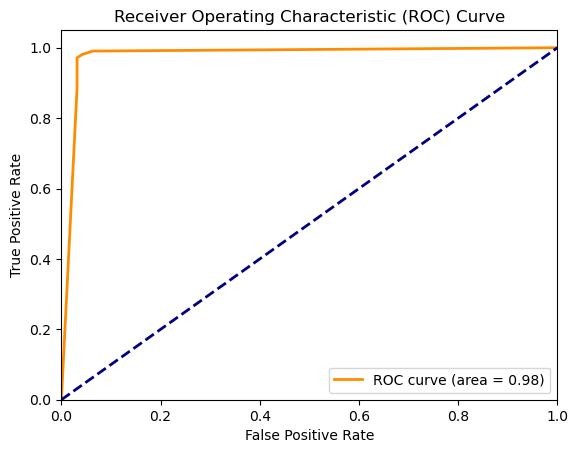

In [12]:
# Compute predicted probabilities
y_pred_proba = dt.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
dt_predicted

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1], dtype=int64)

In [15]:
dt_predict_proba = dt.predict_proba(X_test)
dt_predict_proba.shape

(200, 2)

In [16]:
dt_predict_probability = dt_predict_proba[:,1]
dt_predict_probability

array([1.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.97142857,
       0.        , 0.        , 1.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 0.97142857, 1.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ,
       0.53333333, 0.        , 0.        , 0.        , 0.     

In [17]:
dt_predict_probability.shape

(200,)

In [18]:
# save the model to disk
filename = '../saved_models/decision_tree_model.sav'
pickle.dump(dt, open(filename, 'wb'))

In [19]:
# save the scaler to disk
scaler_filename = "../saved_models/decision_tree_model_scaler"
joblib.dump(scaler, scaler_filename) 

['../saved_models/decision_tree_model_scaler']

# Front End

In [20]:
# Load the scaler
scaler_filename = "../saved_models/decision_tree_model_scaler"
scaler = joblib.load(scaler_filename)

In [21]:
# load the model from disk
filename = '../saved_models/decision_tree_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [22]:
# Prediction - Based on FE values
features_values = np.array([53, 1, 2, 171, 0, 0, 1, 147, 0, 5.3, 3, 3]).reshape(1, -1)

In [23]:
features_values.shape

(1, 12)

In [24]:
scaled_features_values = scaler.transform(features_values)
scaled_features_values.shape

C:\Users\divya\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(1, 12)

In [25]:
fe_model_output = loaded_model.predict(scaled_features_values)
fe_model_output.shape

(1,)

In [26]:
fe_model_output

array([1], dtype=int64)

In [27]:
fe_model_proba_output = loaded_model.predict_proba(scaled_features_values)
fe_model_proba_output.shape

(1, 2)

In [28]:
fe_predict_probability = fe_model_proba_output[:,1]
fe_predict_probability

array([1.])